In [8]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import scipy.signal as signal

import matplotlib.pyplot as plt
%matplotlib inline  

In [55]:
## Emitters are defined by a rate in rpm and an initial phase (in degrees).
## Phase is the bearing from the detector to the emitter (or is it the reciprocal?)
## Emitters are pointed at detector when (wt + phase) == pi

signals = [[12, 0], [12.2,43] ]

## Transform signals to rad/sec and radians phase

def rpm2radpersec(rpm):
    return rpm/60*(2*np.pi)

signals = [[rpm2radpersec(a[0]), np.radians(a[1])] for a in signals]

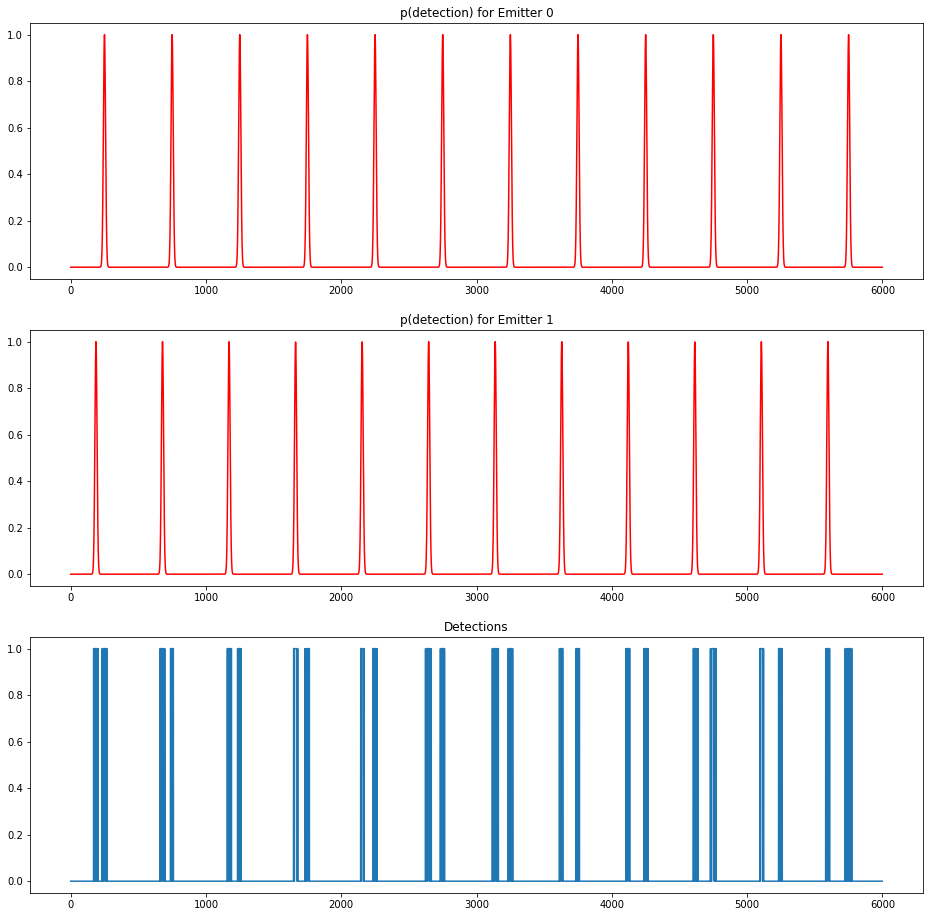

In [58]:
## Detector sampling freq and length of buffer 
sband_hz=100
buffer_secs=60

## Fixed seed for debugging
np.random.seed(0)

detector_mean = np.pi

## Variance defnes the angular "beamwidth" of the detector
detector_var  = 0.1

## Maximum detection probability.  If < 1, detector can give false negative
p_detection_max = 1.0

## prob of random detection, if > 0, detector can give false positive
p_detection_random = 0.00


buffer_len = sband_hz*buffer_secs
buffer = np.zeros((buffer_len))
t = np.arange(0,buffer_len) / sband_hz

plt.figure(figsize=(16, 16))

for i,sig in enumerate(signals):
    angle = (sig[0]*t + sig[1])%(2*np.pi)

    p_detect = stats.norm.pdf(angle,detector_mean,detector_var) * p_detection_max / stats.norm.pdf(0,0,detector_var)
    
    ## Add a constant probability of random noise
    p_detect = np.clip( p_detect, p_detection_random, None )

    plt.subplot(len(signals)+1,1,i+1)
    plt.title("p(detection) for Emitter %d" % i)
    plt.plot(p_detect, color='r')
    
    ## Actually draw samples for detection
    prob = np.random.random(buffer_len)
    
    ## And add to the detection buffer
    buffer = buffer+np.clip( np.sign(p_detect-prob), 0, 1 )
    
## Normalize to down to 0-1
buffer = np.clip( buffer, 0, 1)
    
plt.subplot(len(signals)+1,1,len(signals)+1)
plt.title("Detections")
plt.plot(buffer)
plt.show()  

# Detection

### Autocorrelation?

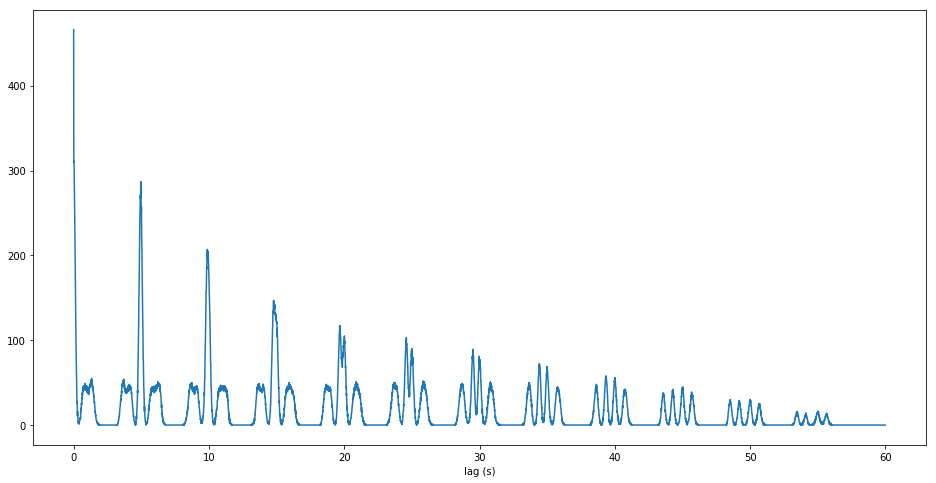

In [59]:
c = np.correlate( buffer, buffer, mode="full" )

## look at half of output
c = c[c.size//2:]

## shift correlates to freq
lag_hz = np.arange(len(c)) / sband_hz

plt.figure(figsize=(16, 8))
plt.plot(lag_hz, c)
plt.xlabel("lag (s)")
plt.show()

In [60]:
# Simple peak finding?

peaks,properties = signal.find_peaks(c)

print(peaks)

## Now look for multiple patterns?

[   2   26   29   34   36   48   50   55   57   59   62   64   68   70
   72   74   78   80   83   86   92   96   98  103  105  110  112  117
  120  124  128  133  136  138  141  144  150  154  160  163  174  177
  179  185  192  322  348  351  354  358  360  362  365  369  372  376
  381  384  388  391  395  398  401  404  411  414  420  423  428  443
  452  457  459  463  472  493  496  501  524  536  538  540  542  554
  557  561  566  569  573  575  580  583  586  590  594  600  604  609
  613  616  620  622  625  628  630  632  634  639  650  655  657  660
  662  665  670  677  811  814  816  822  829  831  839  841  844  853
  858  861  865  868  873  875  880  883  887  890  895  897  903  905
  908  911  916  920  926  938  944  946  949  956  965  983  986  988
  990  993  995 1024 1032 1034 1038 1041 1043 1047 1050 1056 1069 1072
 1077 1079 1082 1085 1088 1091 1096 1099 1101 1106 1109 1111 1113 1117
 1120 1123 1128 1131 1134 1137 1140 1149 1151 1154 1157 1163 1166 1170
 1313 

### Periodogram?

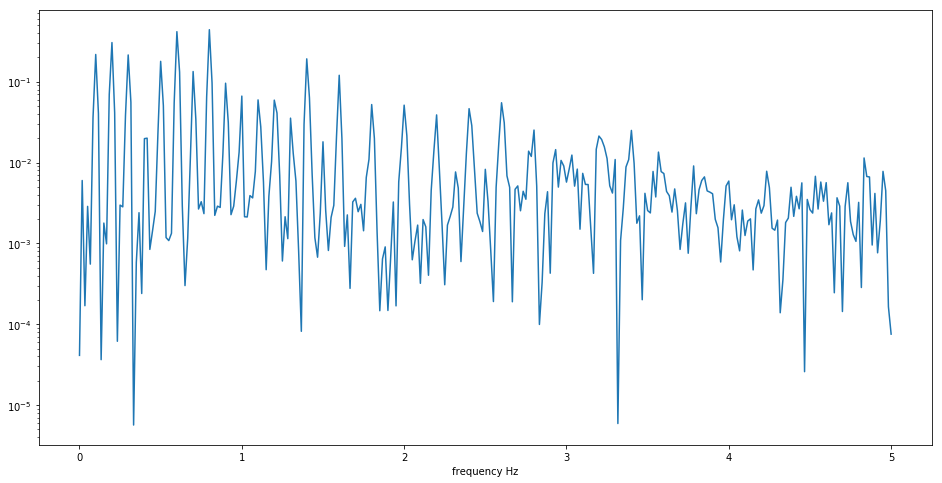

In [18]:
f,pxx = signal.periodogram( buffer, sband_hz, window='hamming' )

plt.figure(figsize=(16, 8))
plt.semilogy(f,pxx)
plt.xlabel("frequency Hz")
plt.show()
